### Load data

In [1]:
import pandas as pd
predictions = pd.read_csv("./data/predictions_up.csv")
predictions.head()

,label,predGbt,predReg,predReg_up
0,0,0.002881,0.000038,0.014922
1,0,0.003244,0.001715,0.022515
2,0,0.011212,0.000592,0.054047
3,0,0.035817,0.002219,0.191879
4,0,0.004102,0.000024,0.014561


### Calibration error

In [2]:
import math
def calibrationError(predictions, modelName, bucketSize = 100):
    count, sumPrediction, sumLabel = 0, 0, 0
    bucketFraudRate = []
    bucketPrediction = []
    bucketErrors = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        sumPrediction = sumPrediction + row[modelName]
        count = count + 1
        if(count == bucketSize):
            predMean = sumPrediction / float(bucketSize)
            fraudRate = sumLabel / float(bucketSize)
            bucketFraudRate.append(fraudRate)
            bucketPrediction.append(predMean)
            bucketErrors.append(math.sqrt((predMean-fraudRate)*(predMean-fraudRate)))
            count, sumPrediction, sumLabel = 0, 0, 0

    return (bucketFraudRate, bucketPrediction, sum(bucketErrors) / float(len(bucketErrors)))

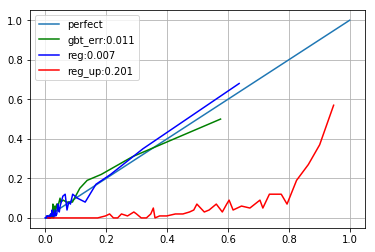

In [3]:
fraudRate_gbt, scores_gbt, err_gbt = calibrationError(predictions, "predGbt")
fraudRate_reg, scores_reg, err_reg = calibrationError(predictions, "predReg")
fraudRate_regup, scores_regup, err_regup = calibrationError(predictions, "predReg_up")
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot([0, 1], [0, 1], label = "perfect")
plt.plot(scores_gbt, fraudRate_gbt, color = 'g', label = "gbt_err:{:.3f}".format(err_gbt))
plt.plot(scores_reg, fraudRate_reg, color = 'b', label = "reg:{:.3f}".format(err_reg))
plt.plot(scores_regup, fraudRate_regup, color = 'r', label = "reg_up:{:.3f}".format(err_regup))
plt.legend()
plt.grid()
plt.show()

In [21]:
print("Calibration error gbt: {:.3f}".format(err_gbt))
print("Calibration error logreg: {:.3f}".format(err_reg))
print("Calibration error upsampled-logreg: {:.3f}".format(err_regup))

Calibration error gbt: 0.011
Calibration error logreg: 0.007
Calibration error upsampled-logreg: 0.201


### Calibration algorithm

In [6]:
def trainCalibration(predictions, modelName, bucketSize = 100):
    count, sumLabel = 0, 0
    buckets = []
    for index, row in predictions.sort_values(by=[modelName]).iterrows():
        sumLabel = sumLabel + row["label"]
        count = count + 1
        if(count == bucketSize):
            fraudRate = sumLabel / float(bucketSize)
            buckets.append((row[modelName], fraudRate))
            count, sumLabel = 0, 0
    
    buckets.append((1,1))
    return buckets

In [7]:
def getCalibratedProb(p, calibBuckets):
    i = 0
    final_p = 0
    while(p > calibBuckets[i][0]):
        final_p = calibBuckets[i][1]
        i = i+1
    return final_p

In [8]:
 predictions_train = pd.read_csv("./data/predictions_train_up.csv")

In [15]:
calibGbt = trainCalibration(predictions_train, "predGbt")
predictions["calibGbt"] = predictions["predGbt"].map(lambda x: getCalibratedProb(x, calibGbt))
err = calibrationError(predictions, "calibGbt")[2]
print("Calibration error calibrated GBT: " + str(err))

Calibration error calibrated GBT: 0.013468817204301082


In [16]:
calibReg = trainCalibration(predictions_train, "predReg")
predictions["calibReg"] = predictions["predReg"].map(lambda x: getCalibratedProb(x, calibReg))
err = calibrationError(predictions, "calibReg")[2]
print("Calibration error calibrated LogReg: " + str(err))

Calibration error calibrated LogReg: 0.010501075268817215


In [17]:
calibReg_up = trainCalibration(predictions_train, "predReg_up")
predictions["calibReg_up"] = predictions["predReg_up"].map(lambda x: getCalibratedProb(x, calibReg_up))
err = calibrationError(predictions, "calibReg_up")[2]
print("Calibration error calibrated upsampled LogReg: " + str(err))


Calibration error calibrated upsampled LogReg: 0.021590322580645162
